### Задача: 
Произвести разведыввательный анализ данных, устранить ошибки, подготовить данные для построения модели.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import plotly
import plotly.graph_objs as go
import plotly.express as px
import warnings
warnings.simplefilter('ignore')

### Data

data = pd.read_csv('stud_math.csv')
print(data.info())
data.sample(5)

### Функции 

In [6]:
def null_percent(df):
    '''Функция табличного вывода процентного соотношения пустых значенй к заполненым'''
    null_dict = {}
    for column in df.columns:
        percent = (np.mean(df[column].isnull())*100).round(1)
        null_dict.setdefault(column, percent)
    percent_null = pd.DataFrame(null_dict, index=['percent_%'], dtype='int8')
    cm = sns.light_palette("gray", as_cmap=True)
    display(percent_null.style.background_gradient(cmap=cm, axis=1))


def box_and_hist(column, bins, df=data):
    '''горизонтальный Boxplot + гистограма'''
    fig, (ax_box, ax_hist) = plt.subplots(2, figsize=(15, 5),
                                          sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], ax=ax_box)
    sns.distplot(df[column], ax=ax_hist, bins=bins)
    ax_box.set_title(f'Распределение значений в {column}')


def corr_matrix(df):
    '''Корреляционная матрица в цвете'''
    fig, ax = plt.subplots(figsize=(10, 7))  # посмотрим корреляционные связи
    sns.heatmap(df.corr(), cmap='terrain', annot=True,
                fmt='.1g', center=0, ax=ax)
    ax.set_title('Корреляционная матрица')


def threshold_min_max(column):
    '''Расчет интерквартильного расстояния, пороги выбросов iqr*1.5'''
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    iqr = perc75 - perc25
    if perc25 == 0:
        min_perc = 0
    else:
        min_perc = int(perc25-iqr*1.5)
    max_perc = int(perc75+iqr*1.5)
    return [min_perc, max_perc]


def replay_on_median(column, df=data):
    '''Замена выбросов медианой'''
    median = df[column].median()
    outliers_min = (df[column] < threshold_min_max(column)[0])
    df[outliers_min] = np.nan
    df[column].fillna(median, inplace=True)

    outliers_max = df[column] > threshold_min_max(column)[1]
    df[outliers_max] = np.nan
    df[column].fillna(median, inplace=True)


def replay_on_mode(column, df=data):
    '''Функция для заполнения пропусков в номинативных значениях на моду'''
    columns_list_o = list(data.select_dtypes(exclude='number').columns)
    for column in columns_list_o:
        df[column] = df[column].apply(lambda x: df[column].mode()[0]
                                      if pd.isnull(x) == True else x)


def get_all_boxplot(ncol, columns_list, column_y):
    '''Функция построения Boxplot по всем полям в сравнении с основным признаком'''
    if len(columns_list) % ncol == 0:
        nrow = len(columns_list)//ncol
    else:
        nrow = len(columns_list)//ncol+1
    if 15//ncol >= 5:
        size_x = ncol*4.5
    else:
        size_x = 15
    size_y = nrow*5
    fig, axes = plt.subplots(nrow, ncol, figsize=(size_x, size_y))
    #fig.update_layout(margin=dict(l=0, r=0, t=0, b=10))

    for i in range(nrow):  # проходим по строкам области рисования
        for j in range(ncol):  # проходим по столбцам области рисования
            if len(columns_list) == 0:  # если характеристики в списке закончились - прекращаем циклы
                break
            else:
                # удаляет первый элемент из списка и возвращает его значение
                column_x = columns_list.pop(0)
                if nrow == 1:
                    sns.boxplot(x=column_x, y=column_y, data=data, ax=axes[j])
                    axes[j].set_title('Boxplot for ' + column_x)
                elif ncol == 1:
                    sns.boxplot(x=column_x, y=column_y, data=data, ax=axes[i])
                    axes[i].set_title('Boxplot for ' + column_x)
                else:
                    sns.boxplot(x=column_x, y=column_y,
                                data=data, ax=axes[i, j])
                    axes[i, j].set_title('Boxplot for ' + column_x)


def get_ttesty(column, df=data):
    '''Функция стачистически значимых параметров по всем полям для оценки по математике'''
    unic_list = df.loc[:, column].value_counts().index[:10]
    comb_list = list(combinations(unic_list, 2))
    for comb in comb_list:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score'])\
                .pvalue <= 0.05/len(comb_list):
            print(
                f'Найдены статистически значимые различия для колонки {column}, пара значений {comb}.')
            break

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
sns.set()

# список  столбцов
columns_list_o = list(data.select_dtypes(exclude='number').columns)
columns_list_n = list(data.select_dtypes(exclude='object').columns)

### Предобработка

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
percent_%,0,0,0,4,6,11,0,6,4,9,4,7,7,1,5,2,9,10,3,4,1,5,8,7,6,2,2,3,3,1


Text(0.5, 1.0, 'Распределение незаполненых значений')

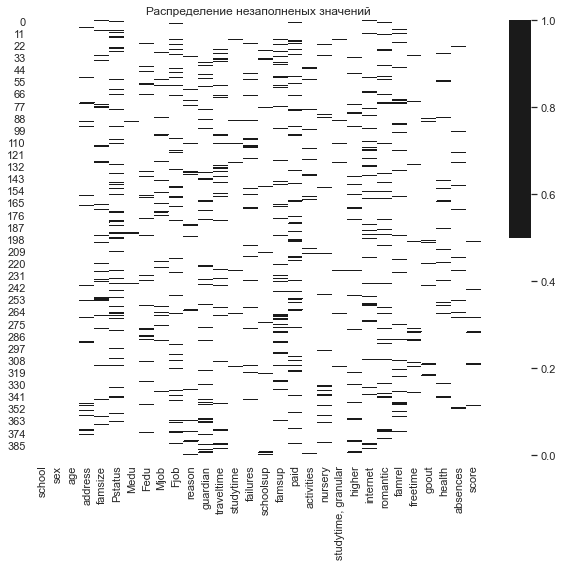

In [342]:
null_percent(data)  # def % незаполненых значений.

fig, ax = plt.subplots(figsize=(10, 8))  # посмотрим  пропуски
colors = ['w', 'k']
sns.heatmap(data.isnull(), cmap=sns.color_palette(colors),
            ax=ax)  # распределение незаполненых значений
ax.set_title('Распределение незаполненых значений')

<!--more-->

**Выводы:**  
Пустые значения распространены равномерно, заполнение пропусков можно не проводить дабы не создавать шум в статистистических показателях.  
Процент пустых значений в столбцах не превышает 11 %, что говорит о возможности использования всех данных в дальнейшей обработке.  
`Удалим пустые значения(NaN) в столбце 'score', основного оценочного признака.`

In [343]:
data = data.dropna(subset=['score'])  # удаление Nan

In [9]:
for colum in data.columns:  # посмотрим все значения в столбцах
    print(f'{colum}, {data[colum].unique()}')
#     print(f'{colum}, {sorted(data[colum].value_counts().index.tolist())}')

school, ['GP' 'MS']
sex, ['F' 'M']
age, [18 17 15 16 19 22 20 21]
address, ['U' nan 'R']
famsize, [nan 'GT3' 'LE3']
Pstatus, ['A' nan 'T']
Medu, [ 4.  1.  3.  2. nan  0.]
Fedu, [ 4.  1.  2.  3. 40. nan  0.]
Mjob, ['at_home' 'health' 'other' 'services' 'teacher' nan]
Fjob, ['teacher' 'other' nan 'health' 'services' 'at_home']
reason, ['course' 'other' 'home' 'reputation' nan]
guardian, ['mother' 'father' 'other' nan]
traveltime, [ 2.  1.  3. nan  4.]
studytime, [ 2.  3.  1. nan  4.]
failures, [ 0.  3. nan  2.  1.]
schoolsup, ['yes' 'no' nan]
famsup, ['no' 'yes' nan]
paid, ['no' nan 'yes']
activities, ['no' 'yes' nan]
nursery, ['yes' 'no' nan]
studytime, granular, [ -6.  -9.  -3.  nan -12.]
higher, ['yes' nan 'no']
internet, [nan 'yes' 'no']
romantic, ['no' nan 'yes']
famrel, [ 4.  5.  3. nan -1.  2.  1.]
freetime, [ 3.  2.  4.  1.  5. nan]
goout, [ 4.  3.  2.  1.  5. nan]
health, [ 3.  5.  1.  2.  4. nan]
absences, [  6.   4.  10.   2.   0.  16.  nan  14.   7.   8.  25.  12.  54.  18.
 

**Выводы:**  
Вариативность значений низкая в среднем 2-5 варианта, за исключением полей пропусков уроков и оценок.  
Все данные корректны, но встречаются ошибки в полях `Fedu, famrel.`  
Поле `studytime, granular` повторяет `studytime`, удалим его.

In [345]:
data.Fedu = data.Fedu.replace(40.0, 4)  # заменим 40 на 4
data.famrel = data.famrel.replace(-1.0, 4)  # заменим -1 на 1
data = data.drop('studytime, granular', axis=1)  # удалим 'studytime, granular'

Text(0.5, 1.0, 'Распределение числовых полей c 4-7 признаками')

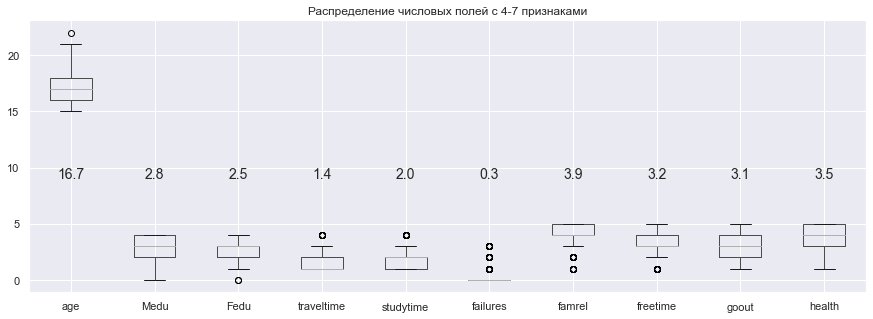

In [346]:
# список числовых столбцов с 4-7 признаками
columns_list_n = list(data.select_dtypes(exclude='object').columns[:10])
fig, ax = plt.subplots(figsize=(15, 5))  # посмотрим  выбросы
data_num = data.loc[:, columns_list_n]
data_num.boxplot(ax=ax)
for i, val in enumerate(data_num.mean()):  # выведем средние значения
    plt.text(i+1, 10, round(val, 1), horizontalalignment='center',
             verticalalignment='top', fontdict={'size': 14})
ax.set_title('Распределение числовых полей c 4-7 признаками')

### Выводы:
Большинство учащихся  15-18 лет, есть несколько учеников более 20 лет.  
Образование отцов в среднем хуже чем матерей, при этом матерей c плохим образованием больше.  
Время в пути и на учебу для большинства одинаковое.  
Большинство(80%) учеников не сообщили о своих внеучебных неудачах(failures) либо их не было.  
Очень мало родителей(23) сообщило о плохих семейных отношениях, у многих все хорошо.  
В среднем свободного времени ученикам хватает, многие проведят его с друзьями.  
Больных мало.  

77


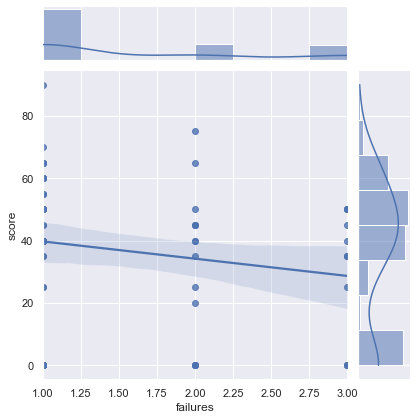

In [347]:
# посмотрим выборку учеников отметивших более одной неудачи.
data_failures = data.query('failures>=1').copy()
print(len(data_failures))
sns.jointplot(x='failures', y='score', data=data_failures,
              kind='reg')  # взамосвязь неудач на оценки

Из выборки 77 учеников видно что чем больше внеучебных неудач тем больше вероятность получить плохую оценку.

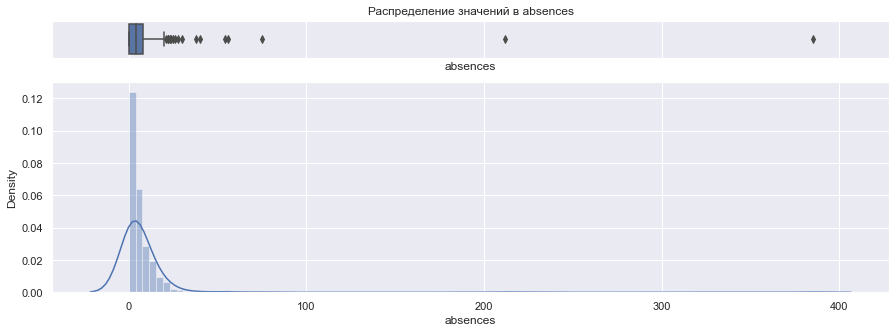

In [348]:
box_and_hist("absences", 100, data)  # посмотрим выбросы в поле прогулов.

Распределение асиммитричное со смещением вправо, при этом выделяется 17 аномальных значений. 
Проверим как сильно влияет большое число прогулов на другие признаки.

17


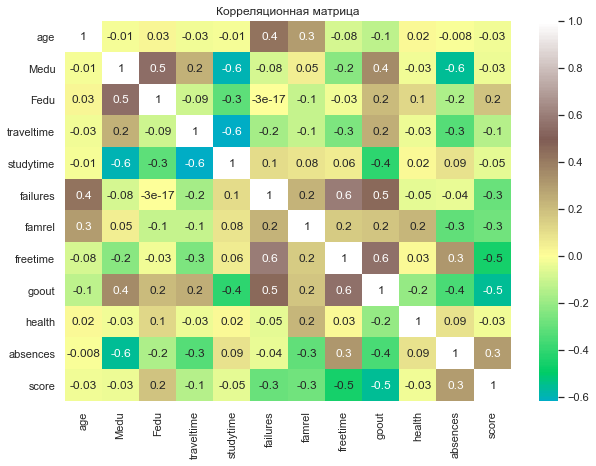

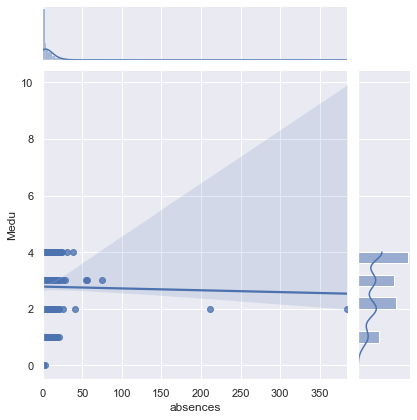

In [349]:
# def максимальный  порог для прогулов
threshold_max = threshold_min_max('absences')[1]
data_shirker = data.query('absences>@threshold_max').copy()
print(len(data_shirker))
corr_matrix(data_shirker)  # def корреляционная матрица для прогульщиков
# взамосвязь образования матери и  прогулов
display(sns.jointplot(x='absences', y='Medu', data=data, kind='reg'))

В целом можно сказать что выборка из 17 прогульщиков значительно повлияла бы на многие параметры, сместив тренд корреляционных связей. Поэтому все аномальные значения приведены к медиане.

In [350]:
# def приведем аномальные значения  к медиане
replay_on_median('absences', data)

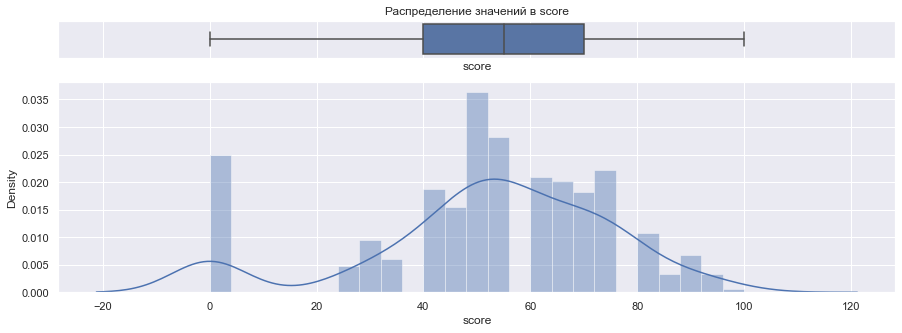

In [351]:
box_and_hist("score", 25)  # def посмотрим распределение в поле оценки.

Распределение бимодальное, выборку можно разделить на плохо сдавших математику и нормально, граница в районе 40 балов.  

67


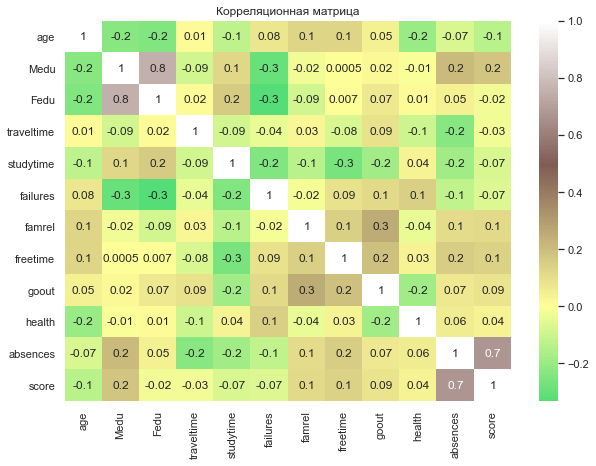

In [352]:
# посмотрим корреляционные связи для "двоечников".
data_stupid = data.query('score<40')
print(len(data_stupid))
corr_matrix(data_stupid)

В группе "двоечников" на оценки влияют прогулы и образование матери, в меньшей степени отношения в семье и свободное время проведеное с друзьями. 

<AxesSubplot:>

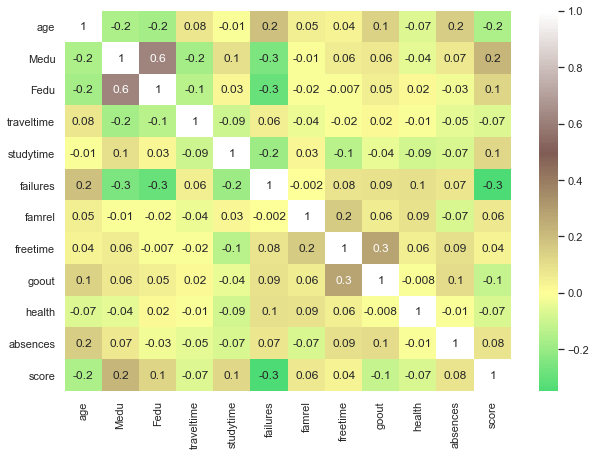

In [353]:
# посмотрим корреляционные связи по всем числовым данным
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(data.corr(), cmap='terrain',
            annot=True, fmt='.1g', center=0, ax=ax)

### Выводы:
Из корреляционной матрицы следует:  
    - образование матерей и отцов как правило одного уровня и влияет на оценки.  
    - свободное время и проведенное время с друзьями имеют взамосвязь, при этом на оценки влияют не сильно.  
    - внеучебные неудачи влияют отрицательно на оценку, но в большей степени на "хорошистов".  
    - высоковозрастные сдают математику хуже.  
    - хорошие отношения в семье добавляют свободного времени.  
    - время в пути, отношения в семье, свободное время, здоровье и прогулы для большинства учеников никак  
    не влияют на оценки.


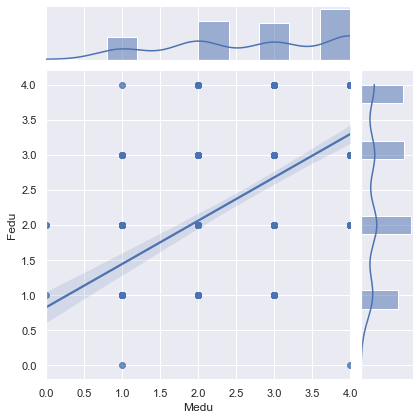

In [354]:
# посмотрим взамосвязь образования отцов и матерей
sns.jointplot(x='Medu', y='Fedu', data=data, kind='reg')

На графике выше видна линейная зависимость образования матерей и отцов.  
Ввиду того что в образовании отцов имеют много пропусков(5%) заполним эти пустые значения как в поле "Medu".

In [355]:
data.Fedu.fillna(data.Medu, inplace=True) # заполним пустые значениями из Medu

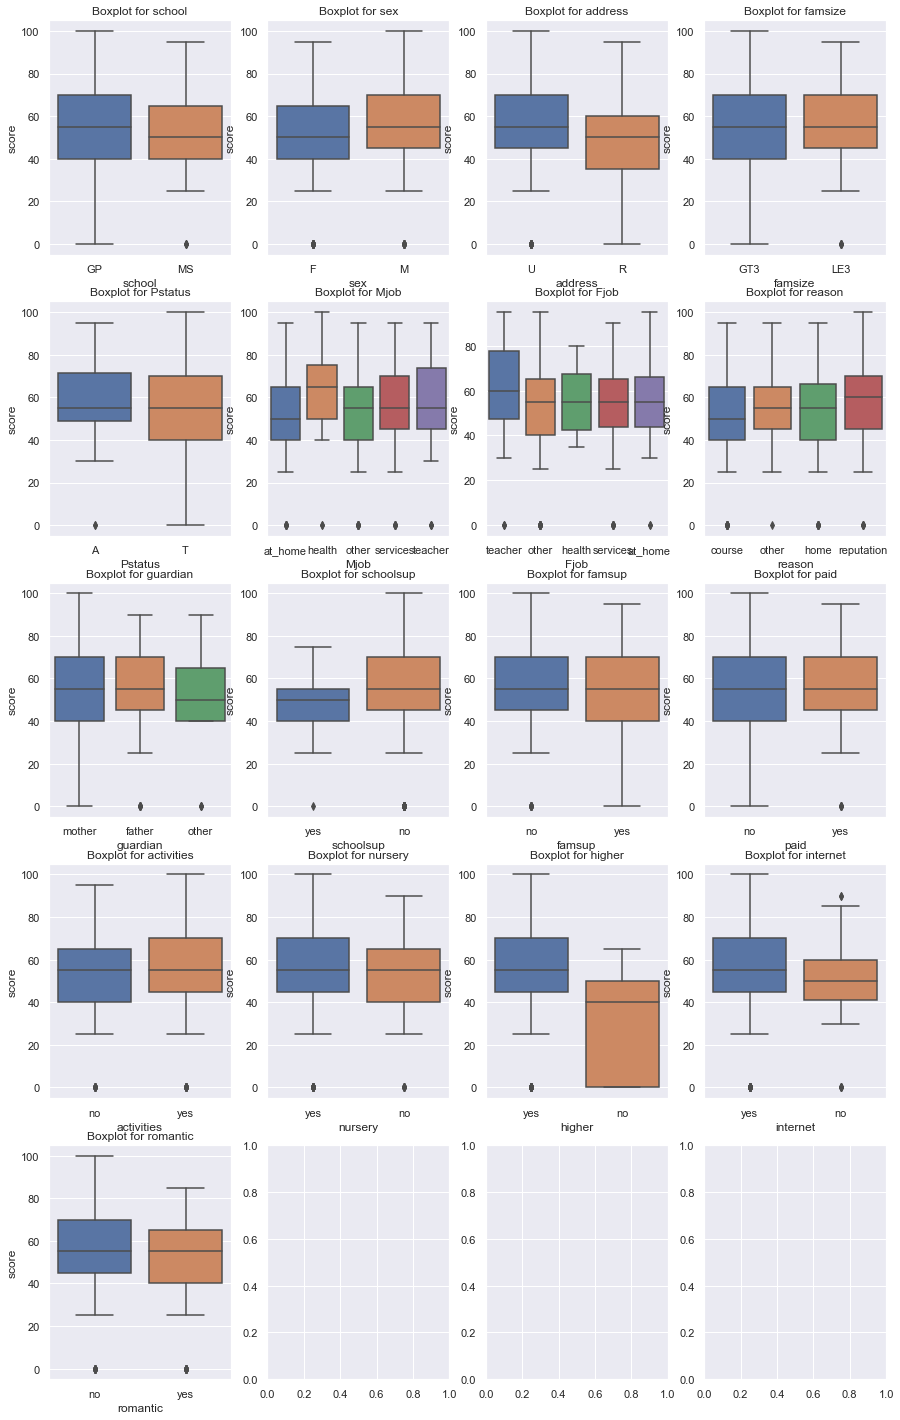

In [356]:
# посмотрим влияние номинативных признаков на оценки
columns_list_o = list(data.select_dtypes(exclude='number').columns)
get_all_boxplot(4, columns_list_o, 'score')

По графикам похоже что все параметры могут влиять на оценку ученика, кроме:  
famsize,  
Pstatus,  
famsup,  
paid,  
activities,  
nursery,  
romantic

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента.

In [357]:
columns_list_o = list(data.select_dtypes(exclude='number').columns)
for col in columns_list_o:  # def
    get_ttesty(col, data)

Найдены статистически значимые различия для колонки sex, пара значений ('F', 'M').
Найдены статистически значимые различия для колонки address, пара значений ('U', 'R').
Найдены статистически значимые различия для колонки Mjob, пара значений ('at_home', 'health').
Найдены статистически значимые различия для колонки paid, пара значений ('no', 'yes').
Найдены статистически значимые различия для колонки higher, пара значений ('yes', 'no').
Найдены статистически значимые различия для колонки romantic, пара значений ('no', 'yes').


# Выводы:

Таблица составлена  корректно, без серьезных ошибок.
Количество пропущенных значений в колонках не превышает 11%.   
Заполнение пропусков считаю не нужным, данных для анализа достаточно.  
Выбросы или отсутствуют, или встречаются в незначительном количестве случаев за исключением прогулов("absences").  
Группу риска("двоечников") стоит изучить  подробнее, так как параметры влияющие на оценки по математике отличаются.   
Хорошая корреляционная связь `Medu` и `Fedu` можно обяснить кругом общения схожего образования.  

Для построения модели предлагается использовать столбцы:  
`score  
Medu  
Fedu  
Mjob  
sex  
address  
paid  
higher  
romantic  
age  
absences  
failures  
famrel`  
Влияют незначительно, либо косвено на другие важные признаки:  
`Fjob  
freetime  
goout  
school  
famsup  
internet  
reason  
studytime`  

Практически не влияют, можно удалить из выборки:  
`studytime, granular  
traveltime  
health  
guardian  
famsize  
Pstatus 
activities  
nursery  
schoolsup  `